# Get Start with [Birds Classification](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)

## Step 0: preparation -- download & organize dataset

Kaggle has a nice [birds classification dataset](https://www.kaggle.com/datasets/gpiosenka/100-bird-species). Download the [data](https://www.kaggle.com/datasets/gpiosenka/100-bird-species/download?datasetVersionNumber=64) and upzip to the `data/` folder so that it has the following structure  
```
-- data\
|  -- birds515\
|    -- images to predict\
|    -- test\
|    -- train\
|    -- valid\
|    birds.csv
|    EfficientNetB0 model-510-(224 X 224)-99.21.h5
```

Let's take a look at the dataset

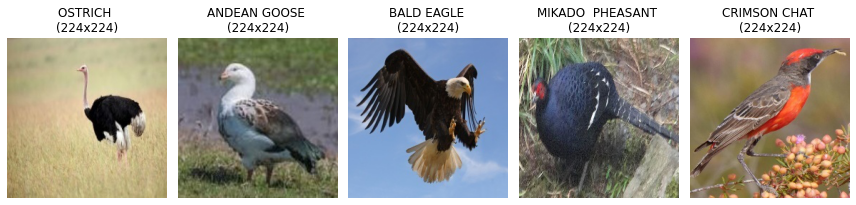

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

n_images = 5
img_dir = '../data/birds515/train'
species = random.sample(os.listdir(img_dir), n_images)

plt.figure(figsize=(12, 5))
for cnt, s in enumerate(species):
    img_name = random.choice(glob(os.path.join(img_dir, s, '*.jpg')))
    img = np.array(Image.open(img_name))
    plt.subplot(1, 5, cnt+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{s} \n({img.shape[0]}x{img.shape[1]})')
plt.tight_layout()

All images have the same size (224x224), it seems only one object exists in each image.

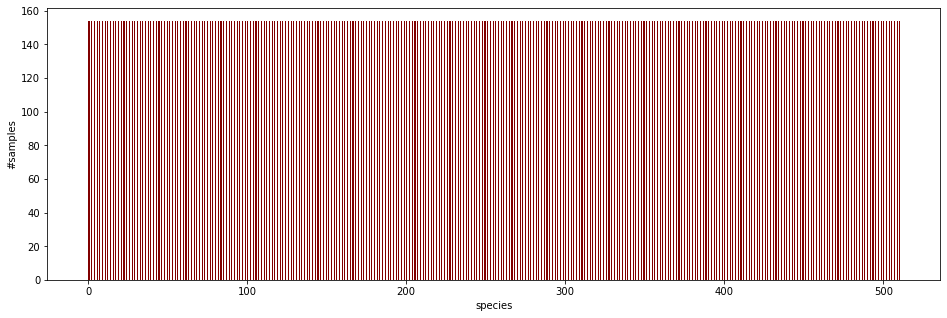

In [2]:
names = []
samples = []
for name in os.listdir(img_dir):
    names.append(name)
    samples.append(len(glob(os.path.join(img_dir, s, '*.jpg'))))
plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(names)), samples, color ='maroon', width = 0.4)
plt.xlabel('species')
plt.ylabel('#samples')
plt.show()

This is also a well balaced dataset

## Step 1: make the pytorch dataset

The directories in this dataset is organized in [pytorch's ImageFolder structure](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), which means we can use torchvision's api to define the dataset directly.  

One last step before making the dataset is to compute the dataset's mean & std for normalization ([why data needs to be normalized](https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d)). We can either use ImageNet's stats (`mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]`) or compute our own from the images in this dataset. Given this dataset focuses mostly on birds in the wild, let's take a look at what is the stats for this dataset first.

First let's get the list of all images files (assume `test/` files are not available)

In [3]:
def dfs_files(parent_dir, ext):
    """DFS search of parent folder for all files with given extension

    Args:
        parent_dir (str): root folder path
        ext (str): extension (e.g., jpg)

    Returns:
        list: list of path to files
    """
    file_list = []
    for root, dirs, files in os.walk(parent_dir):
        path = root.split(os.sep)
        for file in files:
            if ext in file:
                file_list.append(os.path.join(os.sep.join(path), file))
    return file_list
train_dir = '../data/birds515/train'
valid_dir = '../data/birds515/valid'
train_list = dfs_files(train_dir, '.jpg')
valid_list = dfs_files(valid_dir, '.jpg')
print(f'Total sample = {len(train_list+valid_list)}')

Total sample = 84500


Now we can compute the stats. Since the dataset is relatively large, compute running stat instead of loading the dataset directly

In [4]:
from tqdm import tqdm

def running_stats(images):
    """compute mean and std of a dataset

    Args:
        images (list): list of paths to images

    Returns:
        [mean (numpy array), std (numpy array)]: channel wise mean and std of the dataset
    """
    cnt = 0
    mean = 0
    m2 = 0

    for img in tqdm(images):
        cnt += 1
        x = np.mean(np.array(Image.open(img))/255.0, axis=(0, 1))
        delta = x - mean
        mean += delta / cnt
        m2 += delta * (x - mean)

    std = np.sqrt(m2 / (cnt - 1))
    return mean, std
mean, std = running_stats(train_list+valid_list)
print(f'mean={mean}, std={std}')

100%|█████████████████████████████████████| 84500/84500 [01:33<00:00, 904.36it/s]

mean=[0.47377786 0.468924   0.3952328 ], std=[0.1153898  0.10800761 0.13858456]


Compared with ImageNet: `mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]`, this dataset has lower std (because it focuses on birds only). So let's use the dataset's stats.

Now it's finaly time to make the [dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)! 

In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

batch_size = 32
n_workders = 4

# transforms for image
input_size = 224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(input_size)),    # add some spatial variation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
valid_transform = transforms.Compose([
    transforms.Resize(int(input_size/0.875)),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
# define the dataset
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(root=valid_dir, transform=valid_transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, \
                            num_workers=n_workders)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, \
                            num_workers=n_workders)

## Step 2: select the model

Given this is a relatively easy task, we don't need to use a large model. [MobileNetV3](https://arxiv.org/pdf/1905.02244v5.pdf) might be a good choice for this task as it is small and efficient. In addition, Pytorch has official api for MobileNetV3 which we can directly use.

In [6]:
import torch
from torchvision import models
from torchinfo import summary

network = models.mobilenet_v3_small(weights='DEFAULT')

summary(network, input_size=[1, 3, input_size, input_size])

/Users/bohaohuang/miniconda3/envs/tb_py39/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 1000]                 --
├─Sequential: 1-1                                  [1, 576, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 56, 56]           --
│    │    └─Sequential: 3-4                        [1, 16, 56, 56]           744
│    └─InvertedResidual: 2-3                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-5                        [1, 24, 28, 28]           3,864
│    └─InvertedResidual: 2-4                       [1, 24, 28, 28]           --
│    │    └─Sequential: 3-6   

From the summary we can find it is indeed small with ~10m params and it's also not _deep__ in today's standard.

## Step 3: train the model

In [7]:
from torch import nn

learn_rate = 1e-4        # small learn rate since we are finetune

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=network.parameters(), lr=learn_rate)

For each epoch, we need to loop through the dataset, make prediction and calculate the loss & accuracy. Depending on training step or not, we will also do backprop.

In [8]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    """train one epoch, 
    this code is from https://www.learnpytorch.io/04_pytorch_custom_datasets/

    Args:
        model (torch.nn.Module): network model
        dataloader (torch.utils.data.DataLoader): dataloader
        loss_fn (torch.nn.Module): loss function
        optimizer (torch.optim.Optimizer): optimizer
        device (torch.device): torch device to run networks

    Returns:
        float: train loss and accuracy
    """
    model.train()
    train_loss, train_acc = 0, 0
    for _, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn, device):
    """test one epoch, 
    this code is from https://www.learnpytorch.io/04_pytorch_custom_datasets/

    Args:
        model (torch.nn.Module): network model
        dataloader (torch.utils.data.DataLoader): dataloader
        loss_fn (torch.nn.Module): loss function
        device (torch.device): torch device to run networks

    Returns:
        float: test loss and accuracy
    """
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Putting all together, each epoch we do:
1. Training step: compute loss and accuracy on the dataset, backprop
2. Validation step: compute loss and accuracy, evaluation only (no backprop)
3. Keep track of the loss & accuracy 
4. Save the model every 5 epochs

In [9]:
from timeit import default_timer as timer 

def train(model, train_loader, valid_loader, optimizer, loss_fn, epochs, device, save_epoch, model_save_dir):
    train_loss_list, train_acc_list = np.zeros(epochs), np.zeros(epochs)
    valid_loss_list, valid_acc_list = np.zeros(epochs), np.zeros(epochs)

    for epoch in tqdm(range(epochs)):
        start_time = timer()
        train_loss, train_acc = train_step(
            model=model, dataloader=train_loader, loss_fn=loss_fn, optimizer=optimizer, \
            device=device)
        valid_loss, valid_acc = test_step(
            model=model, dataloader=valid_loader, loss_fn=loss_fn, device=device)
        end_time = timer()

        print(
            f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | "
            f"valid_loss: {valid_loss:.4f} | valid_acc: {valid_acc:.4f} | "
            f"time: {end_time-start_time:.3f}s"
        )

        train_loss_list[epoch], train_acc_list[epoch] = train_loss, train_acc
        valid_loss_list[epoch], valid_acc_list[epoch] = valid_loss, valid_acc

        if epoch % save_epoch == 0 and epoch != 0:
            torch.save(network.state_dict(), os.path.join(model_save_dir, f'model_{epoch}.pth'))

    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [10]:
from datetime import datetime

epochs = 60
tag = f'mobilenetv3_{datetime.now().strftime("%m-%d-%Y")}'      # unique fold name to save model
save_epoch = 5                                                  # save model every n epoch
model_save_dir = f'../models/birds515/{tag}'
if (not os.path.exists(model_save_dir)):
    os.makedirs(model_save_dir)

device = torch.device("mps")
network.to(device)
train_loss, train_acc, valid_loss, valid_acc = train(
        network, train_dataloader, valid_dataloader, optimizer, loss_fn, epochs, device, \
        save_epoch, model_save_dir)

  2%|▋                                         | 1/60 [03:55<3:51:07, 235.04s/it]

Epoch: 1 | train_loss: 4.9508 | train_acc: 0.1294 | valid_loss: 1.7233 | valid_acc: 0.6094 | time: 235.035s


  3%|█▍                                        | 2/60 [07:39<3:41:01, 228.65s/it]

Epoch: 2 | train_loss: 2.3770 | train_acc: 0.4694 | valid_loss: 0.7681 | valid_acc: 0.8159 | time: 224.177s


  5%|██                                        | 3/60 [12:20<3:59:58, 252.60s/it]

Epoch: 3 | train_loss: 1.7276 | train_acc: 0.5971 | valid_loss: 0.5188 | valid_acc: 0.8686 | time: 234.707s


  7%|██▊                                       | 4/60 [27:49<8:05:03, 519.70s/it]

Epoch: 4 | train_loss: 1.4338 | train_acc: 0.6606 | valid_loss: 0.3871 | valid_acc: 0.9045 | time: 234.526s


  8%|███▍                                     | 5/60 [52:13<13:08:28, 860.15s/it]

Epoch: 5 | train_loss: 1.2400 | train_acc: 0.7021 | valid_loss: 0.3050 | valid_acc: 0.9241 | time: 222.128s


 10%|████▏                                     | 6/60 [55:58<9:39:58, 644.41s/it]

Epoch: 6 | train_loss: 1.1265 | train_acc: 0.7274 | valid_loss: 0.2804 | valid_acc: 0.9247 | time: 225.504s


 12%|████▌                                  | 7/60 [1:20:09<13:21:54, 907.82s/it]

Epoch: 7 | train_loss: 1.0280 | train_acc: 0.7492 | valid_loss: 0.2400 | valid_acc: 0.9403 | time: 232.624s


 13%|█████                                 | 8/60 [1:41:27<14:48:58, 1025.74s/it]

Epoch: 8 | train_loss: 0.9588 | train_acc: 0.7664 | valid_loss: 0.2259 | valid_acc: 0.9397 | time: 221.227s


 15%|█████▋                                | 9/60 [2:16:30<19:18:14, 1362.64s/it]

Epoch: 9 | train_loss: 0.8969 | train_acc: 0.7792 | valid_loss: 0.2086 | valid_acc: 0.9440 | time: 226.629s


 17%|██████▏                              | 10/60 [2:52:30<22:20:42, 1608.85s/it]

Epoch: 10 | train_loss: 0.8519 | train_acc: 0.7894 | valid_loss: 0.1880 | valid_acc: 0.9526 | time: 226.391s


 18%|██████▊                              | 11/60 [3:36:30<26:11:32, 1924.34s/it]

Epoch: 11 | train_loss: 0.8014 | train_acc: 0.7999 | valid_loss: 0.1770 | valid_acc: 0.9532 | time: 224.134s


 20%|███████▍                             | 12/60 [4:27:05<30:09:44, 2262.18s/it]

Epoch: 12 | train_loss: 0.7657 | train_acc: 0.8101 | valid_loss: 0.1773 | valid_acc: 0.9553 | time: 228.847s


 22%|████████                             | 13/60 [5:17:24<32:31:37, 2491.44s/it]

Epoch: 13 | train_loss: 0.7324 | train_acc: 0.8164 | valid_loss: 0.1667 | valid_acc: 0.9540 | time: 223.004s


 23%|████████▋                            | 14/60 [5:51:37<30:08:41, 2359.16s/it]

Epoch: 14 | train_loss: 0.7132 | train_acc: 0.8211 | valid_loss: 0.1639 | valid_acc: 0.9555 | time: 222.233s


 25%|█████████▎                           | 15/60 [6:21:01<27:14:43, 2179.63s/it]

Epoch: 15 | train_loss: 0.6816 | train_acc: 0.8294 | valid_loss: 0.1542 | valid_acc: 0.9588 | time: 223.050s


 27%|█████████▊                           | 16/60 [6:42:21<23:19:51, 1908.90s/it]

Epoch: 16 | train_loss: 0.6702 | train_acc: 0.8318 | valid_loss: 0.1525 | valid_acc: 0.9581 | time: 224.287s


 28%|██████████▍                          | 17/60 [7:27:57<25:46:17, 2157.62s/it]

Epoch: 17 | train_loss: 0.6442 | train_acc: 0.8385 | valid_loss: 0.1493 | valid_acc: 0.9596 | time: 228.565s


 30%|███████████                          | 18/60 [7:46:57<21:36:08, 1851.64s/it]

Epoch: 18 | train_loss: 0.6218 | train_acc: 0.8433 | valid_loss: 0.1547 | valid_acc: 0.9631 | time: 226.485s


 32%|███████████▋                         | 19/60 [7:50:45<15:32:05, 1364.04s/it]

Epoch: 19 | train_loss: 0.6094 | train_acc: 0.8476 | valid_loss: 0.1354 | valid_acc: 0.9664 | time: 228.155s


 33%|████████████▎                        | 20/60 [7:54:34<11:22:13, 1023.33s/it]

Epoch: 20 | train_loss: 0.5941 | train_acc: 0.8489 | valid_loss: 0.1406 | valid_acc: 0.9621 | time: 229.240s


 35%|█████████████▋                         | 21/60 [7:58:22<8:29:58, 784.59s/it]

Epoch: 21 | train_loss: 0.5730 | train_acc: 0.8549 | valid_loss: 0.1384 | valid_acc: 0.9629 | time: 227.861s


 37%|██████████████▎                        | 22/60 [8:02:11<6:31:21, 617.93s/it]

Epoch: 22 | train_loss: 0.5679 | train_acc: 0.8558 | valid_loss: 0.1374 | valid_acc: 0.9633 | time: 229.274s


 38%|██████████████▉                        | 23/60 [8:05:58<5:08:43, 500.64s/it]

Epoch: 23 | train_loss: 0.5527 | train_acc: 0.8598 | valid_loss: 0.1317 | valid_acc: 0.9657 | time: 227.061s


 40%|███████████████▌                       | 24/60 [8:09:43<4:10:42, 417.84s/it]

Epoch: 24 | train_loss: 0.5436 | train_acc: 0.8619 | valid_loss: 0.1275 | valid_acc: 0.9667 | time: 224.709s


 42%|████████████████▎                      | 25/60 [8:13:33<3:30:48, 361.39s/it]

Epoch: 25 | train_loss: 0.5261 | train_acc: 0.8644 | valid_loss: 0.1389 | valid_acc: 0.9620 | time: 229.680s


 43%|████████████████▉                      | 26/60 [8:17:21<3:02:12, 321.54s/it]

Epoch: 26 | train_loss: 0.5182 | train_acc: 0.8676 | valid_loss: 0.1297 | valid_acc: 0.9641 | time: 228.437s


 45%|█████████████████▌                     | 27/60 [8:42:19<6:11:00, 674.55s/it]

Epoch: 27 | train_loss: 0.5040 | train_acc: 0.8703 | valid_loss: 0.1249 | valid_acc: 0.9649 | time: 250.023s


 47%|█████████████████▎                   | 28/60 [9:18:53<10:02:44, 1130.14s/it]

Epoch: 28 | train_loss: 0.5025 | train_acc: 0.8725 | valid_loss: 0.1310 | valid_acc: 0.9664 | time: 223.271s


 48%|██████████████████▎                   | 29/60 [9:38:36<9:52:14, 1146.27s/it]

Epoch: 29 | train_loss: 0.4958 | train_acc: 0.8728 | valid_loss: 0.1269 | valid_acc: 0.9637 | time: 225.460s


 50%|███████████████████                   | 30/60 [9:57:53<9:34:38, 1149.27s/it]

Epoch: 30 | train_loss: 0.4881 | train_acc: 0.8743 | valid_loss: 0.1261 | valid_acc: 0.9653 | time: 225.975s


 52%|██████████████████▌                 | 31/60 [10:24:43<10:22:17, 1287.49s/it]

Epoch: 31 | train_loss: 0.4723 | train_acc: 0.8793 | valid_loss: 0.1242 | valid_acc: 0.9661 | time: 222.332s


 53%|███████████████████▋                 | 32/60 [10:35:49<8:33:50, 1101.08s/it]

Epoch: 32 | train_loss: 0.4721 | train_acc: 0.8798 | valid_loss: 0.1167 | valid_acc: 0.9680 | time: 223.349s


 55%|████████████████████▎                | 33/60 [10:48:47<7:31:52, 1004.17s/it]

Epoch: 33 | train_loss: 0.4629 | train_acc: 0.8805 | valid_loss: 0.1131 | valid_acc: 0.9703 | time: 223.360s


 57%|████████████████████▉                | 34/60 [11:09:50<7:48:50, 1081.96s/it]

Epoch: 34 | train_loss: 0.4558 | train_acc: 0.8822 | valid_loss: 0.1262 | valid_acc: 0.9653 | time: 227.971s


 58%|█████████████████████▌               | 35/60 [11:34:42<8:22:00, 1204.82s/it]

Epoch: 35 | train_loss: 0.4470 | train_acc: 0.8856 | valid_loss: 0.1271 | valid_acc: 0.9688 | time: 224.844s


 60%|██████████████████████▏              | 36/60 [11:45:33<6:55:31, 1038.80s/it]

Epoch: 36 | train_loss: 0.4412 | train_acc: 0.8866 | valid_loss: 0.1224 | valid_acc: 0.9674 | time: 226.200s


 62%|██████████████████████▊              | 37/60 [12:08:51<7:19:28, 1146.47s/it]

Epoch: 37 | train_loss: 0.4383 | train_acc: 0.8881 | valid_loss: 0.1261 | valid_acc: 0.9649 | time: 228.711s


 63%|███████████████████████▍             | 38/60 [12:43:23<8:42:10, 1424.13s/it]

Epoch: 38 | train_loss: 0.4276 | train_acc: 0.8886 | valid_loss: 0.1243 | valid_acc: 0.9664 | time: 224.464s


 65%|████████████████████████             | 39/60 [13:10:59<8:42:45, 1493.62s/it]

Epoch: 39 | train_loss: 0.4234 | train_acc: 0.8905 | valid_loss: 0.1206 | valid_acc: 0.9707 | time: 226.469s


 67%|████████████████████████▋            | 40/60 [13:33:52<8:05:50, 1457.51s/it]

Epoch: 40 | train_loss: 0.4207 | train_acc: 0.8915 | valid_loss: 0.1277 | valid_acc: 0.9703 | time: 223.482s


 68%|█████████████████████████▎           | 41/60 [13:51:52<7:05:41, 1344.30s/it]

Epoch: 41 | train_loss: 0.4172 | train_acc: 0.8918 | valid_loss: 0.1194 | valid_acc: 0.9719 | time: 226.046s


 70%|█████████████████████████▉           | 42/60 [14:03:24<5:44:33, 1148.53s/it]

Epoch: 42 | train_loss: 0.4119 | train_acc: 0.8939 | valid_loss: 0.1138 | valid_acc: 0.9707 | time: 227.131s


 72%|██████████████████████████▌          | 43/60 [14:20:45<5:16:19, 1116.42s/it]

Epoch: 43 | train_loss: 0.4030 | train_acc: 0.8964 | valid_loss: 0.1262 | valid_acc: 0.9700 | time: 226.296s


 73%|███████████████████████████▏         | 44/60 [15:07:22<7:12:08, 1620.52s/it]

Epoch: 44 | train_loss: 0.4052 | train_acc: 0.8960 | valid_loss: 0.1295 | valid_acc: 0.9672 | time: 227.025s


 75%|███████████████████████████▊         | 45/60 [15:46:30<7:39:40, 1838.67s/it]

Epoch: 45 | train_loss: 0.3939 | train_acc: 0.8991 | valid_loss: 0.1206 | valid_acc: 0.9684 | time: 224.667s


 77%|████████████████████████████▎        | 46/60 [16:08:24<6:32:18, 1681.30s/it]

Epoch: 46 | train_loss: 0.3980 | train_acc: 0.8978 | valid_loss: 0.1136 | valid_acc: 0.9696 | time: 225.289s


 78%|████████████████████████████▉        | 47/60 [16:23:42<5:14:42, 1452.50s/it]

Epoch: 47 | train_loss: 0.3964 | train_acc: 0.8979 | valid_loss: 0.1117 | valid_acc: 0.9710 | time: 225.176s


 80%|█████████████████████████████▌       | 48/60 [16:34:17<4:01:23, 1206.97s/it]

Epoch: 48 | train_loss: 0.3900 | train_acc: 0.8997 | valid_loss: 0.1239 | valid_acc: 0.9688 | time: 252.863s


 82%|██████████████████████████████▏      | 49/60 [16:52:11<3:33:58, 1167.18s/it]

Epoch: 49 | train_loss: 0.3886 | train_acc: 0.8994 | valid_loss: 0.1174 | valid_acc: 0.9700 | time: 227.298s


 83%|███████████████████████████████▋      | 50/60 [16:59:54<2:39:18, 955.87s/it]

Epoch: 50 | train_loss: 0.3793 | train_acc: 0.9014 | valid_loss: 0.1146 | valid_acc: 0.9727 | time: 227.105s


 85%|████████████████████████████████▎     | 51/60 [17:14:02<2:18:31, 923.51s/it]

Epoch: 51 | train_loss: 0.3743 | train_acc: 0.9027 | valid_loss: 0.1071 | valid_acc: 0.9735 | time: 228.494s


 87%|████████████████████████████████▉     | 52/60 [17:23:46<1:49:35, 821.89s/it]

Epoch: 52 | train_loss: 0.3745 | train_acc: 0.9023 | valid_loss: 0.1143 | valid_acc: 0.9711 | time: 262.021s


 88%|█████████████████████████████████▌    | 53/60 [17:41:42<1:44:45, 897.87s/it]

Epoch: 53 | train_loss: 0.3746 | train_acc: 0.9039 | valid_loss: 0.1187 | valid_acc: 0.9684 | time: 225.142s


 90%|██████████████████████████████████▏   | 54/60 [17:47:21<1:13:01, 730.33s/it]

Epoch: 54 | train_loss: 0.3724 | train_acc: 0.9029 | valid_loss: 0.1104 | valid_acc: 0.9723 | time: 226.047s


 92%|████████████████████████████████████▋   | 55/60 [17:58:26<59:13, 710.74s/it]

Epoch: 55 | train_loss: 0.3625 | train_acc: 0.9069 | valid_loss: 0.1218 | valid_acc: 0.9668 | time: 227.644s


 93%|█████████████████████████████████████▎  | 56/60 [18:13:27<51:11, 767.81s/it]

Epoch: 56 | train_loss: 0.3615 | train_acc: 0.9061 | valid_loss: 0.1071 | valid_acc: 0.9731 | time: 226.362s


 95%|███████████████████████████████████▏ | 57/60 [18:52:01<1:01:34, 1231.50s/it]

Epoch: 57 | train_loss: 0.3652 | train_acc: 0.9052 | valid_loss: 0.1115 | valid_acc: 0.9727 | time: 223.982s


 97%|█████████████████████████████████████▋ | 58/60 [19:24:25<48:10, 1445.35s/it]

Epoch: 58 | train_loss: 0.3523 | train_acc: 0.9084 | valid_loss: 0.1169 | valid_acc: 0.9703 | time: 223.546s


 98%|██████████████████████████████████████▎| 59/60 [19:29:40<18:26, 1106.31s/it]

Epoch: 59 | train_loss: 0.3541 | train_acc: 0.9089 | valid_loss: 0.1199 | valid_acc: 0.9688 | time: 221.844s


100%|███████████████████████████████████████| 60/60 [19:33:27<00:00, 1173.46s/it]

Epoch: 60 | train_loss: 0.3526 | train_acc: 0.9091 | valid_loss: 0.1153 | valid_acc: 0.9703 | time: 227.119s


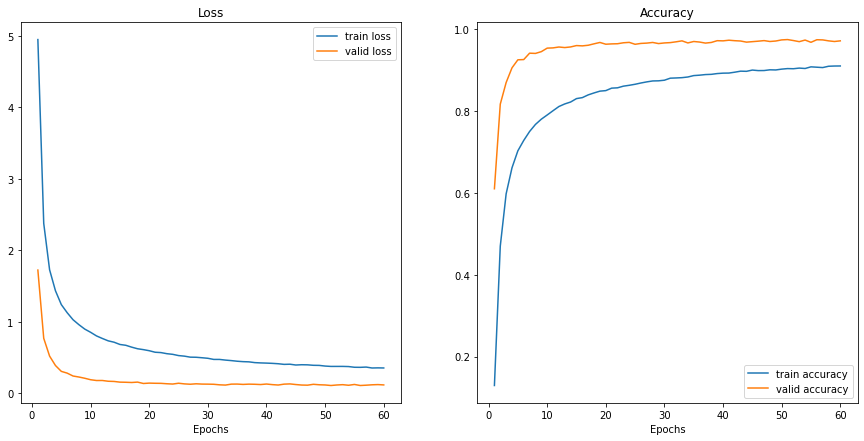

In [11]:
# plot training curves 
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs)+1, train_loss, label='train loss')
plt.plot(np.arange(epochs)+1, valid_loss, label='valid loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs)+1, train_acc, label='train accuracy')
plt.plot(np.arange(epochs)+1, valid_acc, label='valid accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Step 4: evaluate the performance

Now let's check the model's performance on the test dataset

In [12]:
test_dir  = '../data/birds515/test'
test_data  = datasets.ImageFolder(root=test_dir,  transform=valid_transform)
test_dataloader =  DataLoader(test_data, batch_size=batch_size, shuffle=False, \
                                num_workers=n_workders)
test_loss, test_acc = test_step(model=network, dataloader=test_dataloader, loss_fn=loss_fn, device=device)
print(f'Model performance on test dataset: loss={test_loss:.4f}, acc={test_acc:.4f}')

Model performance on test dataset: loss=0.0400, acc=0.9859


The performance on validation/test folder is higher than training, probably valid/test dataset is less diverse as the training set.

## References:
1. [Pytorch custom datasets](https://www.learnpytorch.io/04_pytorch_custom_datasets/#04-pytorch-custom-datasets)
2. [Writing custom datasets](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
3. [Kaggle birds image classification dataset](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)